In [1]:
using Pkg
Pkg.activate("..")
Pkg.develop(["Equilibrium", "IMAS"])
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`
Path `/Users/meneghini/.julia/dev/Equilibrium` exists and looks like the correct package. Using existing path.
Path `/Users/meneghini/.julia/dev/IMAS` exists and looks like the correct package. Using existing path.
   Resolving package versions...
  No Changes to `~/.julia/dev/FUSE/Project.toml`
  No Changes to `~/.julia/dev/FUSE/Manifest.toml`


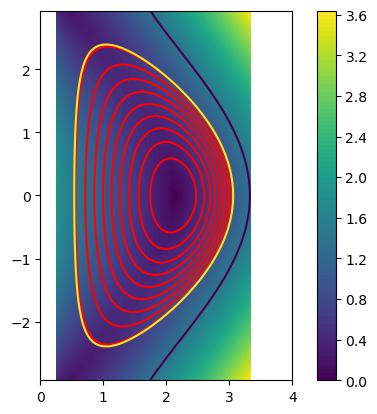

PyObject <matplotlib.colorbar.Colorbar object at 0x7f99c3d4b650>

In [229]:
R0 = 1.8
δ = 0.6
ϵ = 0.7
κ = 1.9
B0 = 2.0
qstar = 1.5
beta_t = 0.16

eq0=FUSE.init(IMAS.equilibrium(), 0.0; B0, R0, ϵ, δ, κ, beta_t, qstar)
eqactor=FUSE.SolovevEquilibriumActor(eq0, 0.0);

FUSE.step(eqactor; verbose=false)

eq1=FUSE.finalize(eqactor,101);
eqt = eq1.time_slice[1]

using PyPlot
# using Equilibrium

Bp=sqrt.(eqt.profiles_2d[1].b_field_z.^2.0.+eqt.profiles_2d[1].b_field_r.^2.0)

PyPlot.figure()
CS=PyPlot.contour(eqt.profiles_2d[1].grid.dim1,
               eqt.profiles_2d[1].grid.dim2,
    transpose(eqt.profiles_2d[1].psi),levels=sort(eqt.profiles_1d.psi[1:11:end]),colors="r")
CS=PyPlot.contourf(eqt.profiles_2d[1].grid.dim1,
               eqt.profiles_2d[1].grid.dim2,
               transpose(Bp),levels=100)
PyPlot.contour(eqt.profiles_2d[1].grid.dim1,
              eqt.profiles_2d[1].grid.dim2,
    transpose(eqt.profiles_2d[1].psi),[eqt.profiles_1d.psi[end]-1,eqt.profiles_1d.psi[end]])
PyPlot.gca().set_aspect("equal")
PyPlot.gca().set_xlim([0,4])
PyPlot.colorbar(CS)

257
  0.155575 seconds (1.47 M allocations: 91.156 MiB)
129
  0.053681 seconds (576.51 k allocations: 34.238 MiB)
65
  0.023680 seconds (281.14 k allocations: 15.618 MiB)
33


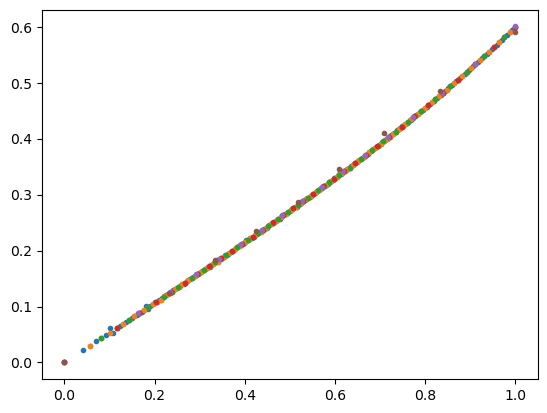

  0.013695 seconds (163.59 k allocations: 8.710 MiB)
17
  0.009255 seconds (109.23 k allocations: 5.603 MiB)
9
  0.007402 seconds (81.04 k allocations: 4.069 MiB)


In [214]:
PyPlot.figure()
for res in reverse(Vector{Int}(2.0.^collect(3:8).+1))
    println(res)
    @time eq1=FUSE.finalize(eqactor,res)
    eqt = eq1.time_slice[1]
    PyPlot.plot(eqt.profiles_1d.rho_tor_norm,eqt.profiles_1d.triangularity_lower,".")
#        PyPlot.axvline(0.95,color="r")
#        PyPlot.plot(0.95,eqt.global_quantities.q_95,"or")
    
end

In [490]:
time_slice=eqt
println(size(time_slice.profiles_1d.rho_tor_norm))
println(size(time_slice.profiles_1d.q))


(513,)
(17,)


LoadError: syntax: unexpected ","

  0.949981 seconds (4.17 M allocations: 304.688 MiB, 11.02% gc time)


LoadError: MethodError: no method matching CubicSplineInterpolation(::Tuple{Vector{Float64}}, ::Vector{Float64})
[0mClosest candidates are:
[0m  CubicSplineInterpolation([91m::AbstractRange[39m, ::AbstractVector{T} where T; bc, extrapolation_bc) at /Users/meneghini/.julia/packages/Interpolations/GIn2o/src/convenience-constructors.jl:12
[0m  CubicSplineInterpolation([91m::Tuple{Vararg{AbstractRange, N}}[39m, ::AbstractArray{T, N}; bc, extrapolation_bc) where {N, T} at /Users/meneghini/.julia/packages/Interpolations/GIn2o/src/convenience-constructors.jl:29

In [286]:
using Interpolations
tmp=Interpolations.interpolate((eqt.profiles_2d[1].grid.dim1,eqt.profiles_2d[1].grid.dim2), eqt.profiles_2d[1].psi, Gridded(Linear()))
Interpolations.gradient(tmp, 2.0,0.0)

2-element StaticArrays.SVector{2, Float64} with indices SOneTo(2):
 -0.40540399085741985
  0.039713413151636345

In [199]:
using Equilibrium
psi=Equilibrium.psi_limits(eq.S)
psi=collect(range(psi[1],psi[end],length=100))
psin=collect(range(0.0,1.0,length=length(psi)))
p=Equilibrium.pressure(eq.S,psi)
pprime=Equilibrium.pressure_gradient(eq.S,psi)
f=Equilibrium.poloidal_current(eq.S,psi)
fprime=Equilibrium.poloidal_current_gradient(eq.S,psi)
mu0 = 4*pi*1e-7

function Psi(M::AbstractEquilibrium, dx=0.01,dy=0.01)
    xlims, ylims = limits(M)
    x = range(xlims...,step=dx)
    y = range(ylims...,step=dy)
    return collect(x),collect(y),[M(xx,yy) for xx in x, yy in y]
end

levels=sort(range(Equilibrium.psi_limits(eq.S)...,length=110))

x,y,PSI=Psi(eq.S)
PyPlot.contour(x,y,transpose(PSI),tmp)
PyPlot.gca().set_aspect("equal")
#PyPlot.plot(psin,f.*fprime)

LoadError: UndefVarError: tmp not defined

In [22]:
using Printf
digits = -Int(log10(1E-9))
txt = "α=%3.$(digits)f β_t=%3.$(digits)e precision=%3.$(digits)e\n"

@printf(txt, 1,2,3)

LoadError: LoadError: MethodError: no method matching Printf.Format(::Int64)
[0mClosest candidates are:
[0m  Printf.Format(::S, [91m::Vector{UnitRange{Int64}}[39m, [91m::T[39m) where {S, T} at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Printf/src/Printf.jl:64
[0m  Printf.Format([91m::AbstractString[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Printf/src/Printf.jl:80
in expression starting at In[22]:5